In [100]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

In [101]:
# Check if cuda is on or not and set it.
device = "cuda" if torch.cuda.is_available() else "cpu"
device_count = torch.cuda.device_count()
print(device)
print(device_count)

cuda
1


In [102]:
# Create data
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start=start,end=end,step = step,device= device).unsqueeze(dim=1)

y = weight*X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]], device='cuda:0'),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]], device='cuda:0'))

In [103]:
# Splitting data into training and test 
train_split_index = int(0.8*len(X))
X_train, y_train = X[:train_split_index],y[:train_split_index]
X_test, y_test = X[train_split_index:], y[train_split_index:]

In [104]:
def plot_data(x_train, y_train,x_test,y_test,predictions = None):

    train = plt.scatter(x=x_train,y= y_train,c='red',s = 5)
    test = plt.scatter(x = x_test, y = y_test,c='g', s = 5)
    if predictions is not None:
        predictions = plt.scatter(x=x_test,y=predictions,c='tab:orange', s = 5)
    plt.title("Train Data")
    plt.xlabel("x-label")
    plt.ylabel("y-label")
    plt.legend(["train","test", "predictions"])
    plt.show()


In [105]:
# Build Regression model using pytorch

from torch import nn

class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1,out_features=1)
        
    def forward(self,x:torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)


In [106]:
# Create a random seed
torch.manual_seed(42)

# create model
reg_model = LinearRegression()

# Check random parameters
reg_model.state_dict()

# set model to work on GPU
reg_model.to(device)



LinearRegression(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [107]:
def transferToCpu(t:torch.Tensor):
    return torch.tensor(t).clone().detach().cpu().numpy()

/tmp/ipykernel_24822/1646531776.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t).clone().detach().cpu().numpy()


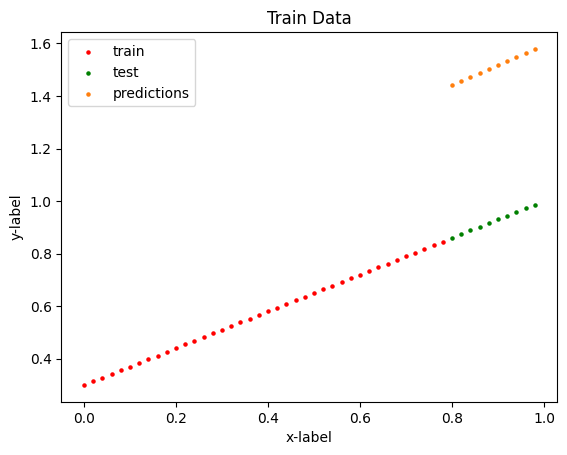

In [108]:
with torch.inference_mode():
    y_preds = reg_model(X_test)

plot_data(x_train=transferToCpu(X_train),
          y_train= transferToCpu(y_train),
          x_test= transferToCpu(X_test), 
          y_test= transferToCpu(y_test),
          predictions= transferToCpu(y_preds))

In [109]:
# set loss function
loss_fn = nn.L1Loss()
# set optimizer
optimizer = torch.optim.SGD(reg_model.parameters(),lr= 0.01)

In [110]:
def predict():
    reg_model.eval()
    with torch.inference_mode():
        y_preds = reg_model(X_test)
    
    loss = loss_fn(y_preds,y_test)
    return loss, y_preds

In [111]:
# train the network
epochs = 100

train_losses = []
test_losses = []

for ep in range(epochs):
    reg_model.train()
    # doing the feed_forward
    y_train_preds = reg_model(X_train)

    #calculate the loss
    train_loss = loss_fn(y_train_preds,y_train)

    print(ep,":",train_loss)

    optimizer.zero_grad()

    #calculate gradient descent
    train_loss.backward()

    optimizer.step()

    if ep % 10 == 0:
        train_losses.append(train_loss)
        test_cost, _ = predict()
        test_losses.append(test_cost)


0 : tensor(0.5552, device='cuda:0', grad_fn=<MeanBackward0>)
1 : tensor(0.5437, device='cuda:0', grad_fn=<MeanBackward0>)
2 : tensor(0.5321, device='cuda:0', grad_fn=<MeanBackward0>)
3 : tensor(0.5206, device='cuda:0', grad_fn=<MeanBackward0>)
4 : tensor(0.5091, device='cuda:0', grad_fn=<MeanBackward0>)
5 : tensor(0.4976, device='cuda:0', grad_fn=<MeanBackward0>)
6 : tensor(0.4861, device='cuda:0', grad_fn=<MeanBackward0>)
7 : tensor(0.4745, device='cuda:0', grad_fn=<MeanBackward0>)
8 : tensor(0.4630, device='cuda:0', grad_fn=<MeanBackward0>)
9 : tensor(0.4515, device='cuda:0', grad_fn=<MeanBackward0>)
10 : tensor(0.4400, device='cuda:0', grad_fn=<MeanBackward0>)
11 : tensor(0.4284, device='cuda:0', grad_fn=<MeanBackward0>)
12 : tensor(0.4169, device='cuda:0', grad_fn=<MeanBackward0>)
13 : tensor(0.4054, device='cuda:0', grad_fn=<MeanBackward0>)
14 : tensor(0.3939, device='cuda:0', grad_fn=<MeanBackward0>)
15 : tensor(0.3824, device='cuda:0', grad_fn=<MeanBackward0>)
16 : tensor(0.3708

10


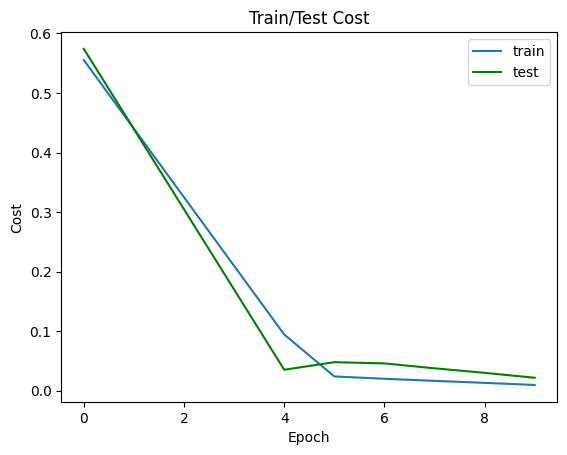

In [112]:
x_epoch = np.arange(10)

train_losses = torch.tensor(train_losses).clone().detach().cpu().numpy()
test_losses = torch.tensor(test_losses).clone().detach().cpu().numpy()

print(len(train_losses))

plt.plot(x_epoch,train_losses)
plt.plot(x_epoch,test_losses,color='green')

plt.title("Train/Test Cost")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.legend(["train","test",])
plt.show()

/tmp/ipykernel_24822/1646531776.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t).clone().detach().cpu().numpy()


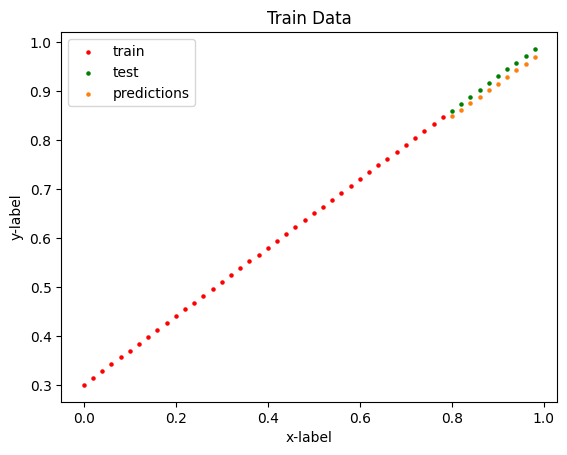

In [113]:
loss, y_pred = predict()

plot_data(x_train=transferToCpu(X_train),
          y_train= transferToCpu(y_train), 
          x_test= transferToCpu(X_test), 
          y_test= transferToCpu(y_test),
            predictions= transferToCpu(y_pred))

In [114]:
reg_model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6691]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3130], device='cuda:0'))])